In [6]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.pipeline import make_pipeline
from transformers import BertTokenizer, TFBertForSequenceClassification
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import shutil

# Load and Preprocess Data

In [7]:
TRAIN_CSV = "/kaggle/input/twitter-entity-sentiment-analysis/twitter_training.csv"
VAL_CSV = "/kaggle/input/twitter-entity-sentiment-analysis/twitter_validation.csv"

cols = ["id", "entity", "sentiment", "tweet"]
df_train = pd.read_csv(TRAIN_CSV, header=None, names=cols)
df_val = pd.read_csv(VAL_CSV, header=None, names=cols)

keep_labels = ["Positive", "Negative", "Neutral"]
df_train = df_train[df_train["sentiment"].isin(keep_labels)].reset_index(drop=True)
df_val = df_val[df_val["sentiment"].isin(keep_labels)].reset_index(drop=True)

def clean_text(texts):
    return texts.str.replace(r"http\S+|www\S+|https\S+", "", regex=True)\
                .str.replace(r"@\w+", "", regex=True)\
                .str.replace(r"[^A-Za-z\s]", "", regex=True)\
                .str.lower()

df_train['clean_text'] = clean_text(df_train['tweet'])
df_val['clean_text'] = clean_text(df_val['tweet'])

df_train = df_train.dropna(subset=["clean_text"]).reset_index(drop=True)
df_val = df_val.dropna(subset=["clean_text"]).reset_index(drop=True)

# Visualize Sentiment Distribution

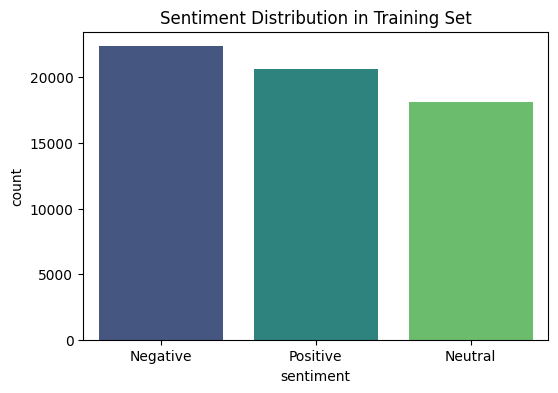

In [8]:
plt.figure(figsize=(6,4))
sns.countplot(data=df_train, x="sentiment", order=df_train["sentiment"].value_counts().index, palette="viridis")
plt.title("Sentiment Distribution in Training Set")
plt.show()

# WordCloud Visualization

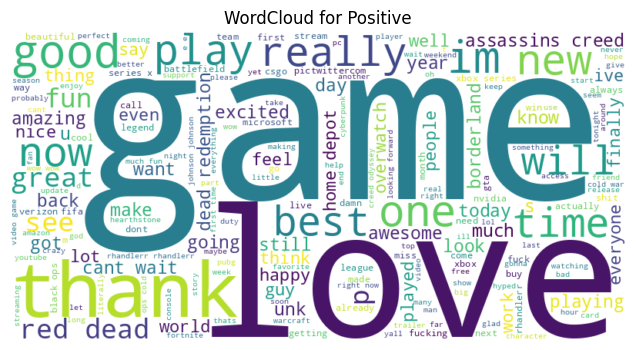

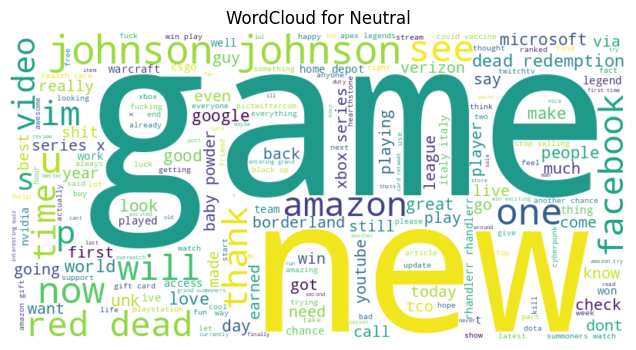

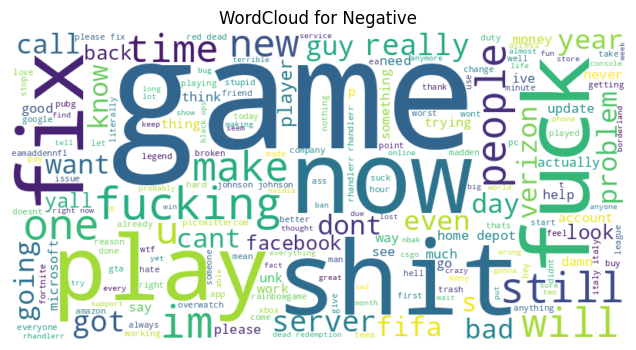

In [9]:
for sentiment in df_train["sentiment"].unique():
    wc = WordCloud(width=800, height=400, background_color="white").generate(
        " ".join(df_train[df_train["sentiment"] == sentiment]["clean_text"])
    )
    plt.figure(figsize=(8,4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"WordCloud for {sentiment}")
    plt.show()

# TF-IDF + Logistic Regression Model

In [10]:
tfidf_lr_pipeline = make_pipeline(
    TfidfVectorizer(max_features=10000, ngram_range=(1,2)),
    LogisticRegression(max_iter=1000)
)

print("Training TF-IDF + Logistic Regression model...")
tfidf_lr_pipeline.fit(df_train['clean_text'], df_train['sentiment'])

val_preds_tfidf_lr = tfidf_lr_pipeline.predict(df_val['clean_text'])
print("TF-IDF + Logistic Regression Classification Report:")
print(classification_report(df_val['sentiment'], val_preds_tfidf_lr))

train_preds_tfidf_lr = tfidf_lr_pipeline.predict(df_train['clean_text'])
train_accuracy = accuracy_score(df_train['sentiment'], train_preds_tfidf_lr)
val_accuracy = accuracy_score(df_val['sentiment'], val_preds_tfidf_lr)
print(f"TF-IDF + Logistic Regression Training Accuracy: {train_accuracy:.4f}")
print(f"TF-IDF + Logistic Regression Validation Accuracy: {val_accuracy:.4f}")

Training TF-IDF + Logistic Regression model...
TF-IDF + Logistic Regression Classification Report:
              precision    recall  f1-score   support

    Negative       0.89      0.94      0.91       266
     Neutral       0.93      0.85      0.89       285
    Positive       0.91      0.94      0.92       277

    accuracy                           0.91       828
   macro avg       0.91      0.91      0.91       828
weighted avg       0.91      0.91      0.91       828

TF-IDF + Logistic Regression Training Accuracy: 0.8553
TF-IDF + Logistic Regression Validation Accuracy: 0.9094


# Prepare Data for BERT Fine-tuning

In [13]:
MODEL_NAME = "bert-base-uncased"
MAX_LEN = 64
BATCH_SIZE = 16
EPOCHS = 2

tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

def encode_texts(texts, max_length=MAX_LEN):
    enc = tokenizer(
        texts.tolist(),
        padding="max_length",
        truncation=True,
        max_length=max_length,
        return_tensors="tf"
    )
    return enc["input_ids"], enc["attention_mask"]

train_input_ids, train_attention_mask = encode_texts(df_train["tweet"])
val_input_ids, val_attention_mask = encode_texts(df_val["tweet"])

label_map = {"Positive": 0, "Negative": 1, "Neutral": 2}
train_labels = tf.convert_to_tensor(df_train["sentiment"].map(label_map).values, dtype=tf.int32)
val_labels = tf.convert_to_tensor(df_val["sentiment"].map(label_map).values, dtype=tf.int32)

def build_dataset(input_ids, attention_mask, labels=None, shuffle=False, batch_size=BATCH_SIZE):
    if labels is not None:
        ds = tf.data.Dataset.from_tensor_slices((
            {"input_ids": input_ids, "attention_mask": attention_mask},
            labels
        ))
    else:
        ds = tf.data.Dataset.from_tensor_slices(
            {"input_ids": input_ids, "attention_mask": attention_mask}
        )
    if shuffle:
        ds = ds.shuffle(2048, seed=42)
    ds = ds.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return ds

train_ds = build_dataset(train_input_ids, train_attention_mask, train_labels, shuffle=True)
val_ds = build_dataset(val_input_ids, val_attention_mask, val_labels)

# Fine-tune BERT Model

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Training BERT model...
Epoch 1/2
3821/3821 [==============================] - 901s 224ms/step - loss: 0.4909 - accuracy: 0.8106 - val_loss: 0.3700 - val_accuracy: 0.8671
Epoch 2/2
52/52 [==============================] - 7s 77ms/step
BERT Classification Report:
              precision    recall  f1-score   support

    Positive       0.96      0.89      0.92       277
    Negative       0.99      0.89      0.94       266
     Neutral       0.83      0.98      0.90       285

    accuracy                           0.92       828
   macro avg       0.93      0.92      0.92       828
weighted avg       0.93      0.92      0.92       828



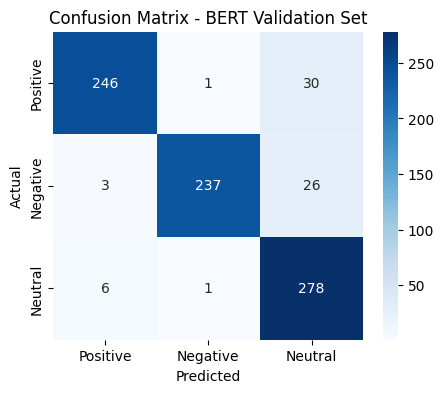

In [14]:
strategy = tf.distribute.get_strategy()
with strategy.scope():
    bert_model = TFBertForSequenceClassification.from_pretrained(
        MODEL_NAME,
        num_labels=3,
        from_pt=True
    )
    optimizer = tf.keras.optimizers.Adam(learning_rate=2e-5)
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    bert_model.compile(optimizer=optimizer, loss=loss_fn, metrics=["accuracy"])

print("Training BERT model...")
bert_model.fit(train_ds, validation_data=val_ds, epochs=EPOCHS)

val_preds_logits = bert_model.predict(val_ds).logits
val_preds_bert = np.argmax(val_preds_logits, axis=1)

print("BERT Classification Report:")
print(classification_report(df_val["sentiment"].map(label_map), val_preds_bert, target_names=["Positive","Negative","Neutral"]))

cm = confusion_matrix(df_val["sentiment"].map(label_map), val_preds_bert)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues",
            xticklabels=label_map.keys(),
            yticklabels=label_map.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix - BERT Validation Set")
plt.show()

# Logistic Regression on BERT Embeddings and Testing in Notebook

In [ ]:
import random
import pandas as pd

N = 10 
sample_df = df_val.sample(N, random_state=42).reset_index(drop=True)

sample_input_ids, sample_attention_mask = encode_texts(sample_df["tweet"])

sample_ds = build_dataset(sample_input_ids, sample_attention_mask)

sample_logits = bert_model.predict(sample_ds).logits
sample_preds = np.argmax(sample_logits, axis=1)

reverse_label_map = {v: k for k, v in label_map.items()}
sample_df["Predicted_Sentiment"] = [reverse_label_map[p] for p in sample_preds]

display(sample_df[["tweet", "sentiment", "Predicted_Sentiment"]])

1/1 [==============================] - 4s 4s/step


,tweet,sentiment,Predicted_Sentiment
0,I actually quite like the design of the ps5. I...,Positive,Positive
1,I can get on the phone with @Verizon but I can...,Positive,Positive
2,hella good options and i loved all of these ga...,Positive,Positive
3,You have no idea how ready I am for this. Give...,Neutral,Neutral
4,@NBA2K @2KSupport @LD2K @Beluba can y’all ple...,Negative,Negative
5,Don’t understand why they port this instead of...,Negative,Negative
6,wtf,Negative,Negative
7,#Indigo Urgent Care looks to Microsoft Teams a...,Positive,Neutral
8,My goodness @PlayOverwatch your matchmaking in...,Negative,Negative
9,Let's all agree to completely trash the inevit...,Negative,Negative


In [ ]:
import joblib

joblib.dump(tfidf_lr_pipeline, "tfidf_lr_model.pkl")
bert_model.save_pretrained("bert_sentiment_model")
tokenizer.save_pretrained("bert_tokenizer")

import zipfile
import os

with zipfile.ZipFile("sentiment_models.zip", "w") as zipf:
    zipf.write("tfidf_lr_model.pkl")
    
    for folder in ["bert_sentiment_model", "bert_tokenizer"]:
        for root, dirs, files in os.walk(folder):
            for file in files:
                file_path = os.path.join(root, file)
                arcname = os.path.relpath(file_path, start=os.path.dirname(folder))
                zipf.write(file_path, arcname)

from IPython.display import FileLink
FileLink("sentiment_models.zip")

/kaggle/working/sentiment_models.zip